In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "2525",
                             database = "ecommerce")

cur = db.cursor()


# List all unique cities where customers are located.

In [3]:
query = """ select distinct (customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#  Count the number of orders placed in 2017.

In [5]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total order placed in 2017 are", data [0] [0]

('total order placed in 2017 are', 135303)

# Find the total sales per category.

In [9]:
query = """ select upper(products.product_category) category,
round(sum(payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
GROUP BY products.product_category
"""


cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category","Sales"] )
print (df)

                       Category        Sales
0                     PERFUMERY  13681943.82
1          FURNITURE DECORATION  38614762.58
2                     TELEPHONY  13145815.37
3                BED TABLE BATH  46238949.12
4                    AUTOMOTIVE  23011946.94
..                          ...          ...
69               CDS MUSIC DVDS     32384.61
70                   LA CUISINE     78665.31
71  FASHION CHILDREN'S CLOTHING     21213.09
72                     PC GAMER     58709.61
73       INSURANCE AND SERVICES      8761.77

[74 rows x 2 columns]


 # Calculate the percentage of orders that were paid in installments.

In [11]:
query = """ select (sum(case when payment_installments >= 1 then 1 
else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()
"The percentage of orders that were paid in installments is", data [0] [0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.

<function matplotlib.pyplot.show(close=None, block=None)>

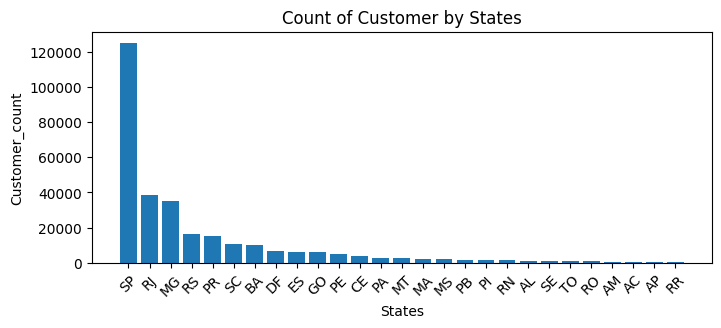

In [3]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by="customer_count", ascending=False)  


plt.figure(figsize = (8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation = 45)
plt.xlabel("States")
plt.ylabel("Customer_count")
plt.title("Count of Customer by States")
plt.show

# Calculate the number of orders per month in 2018

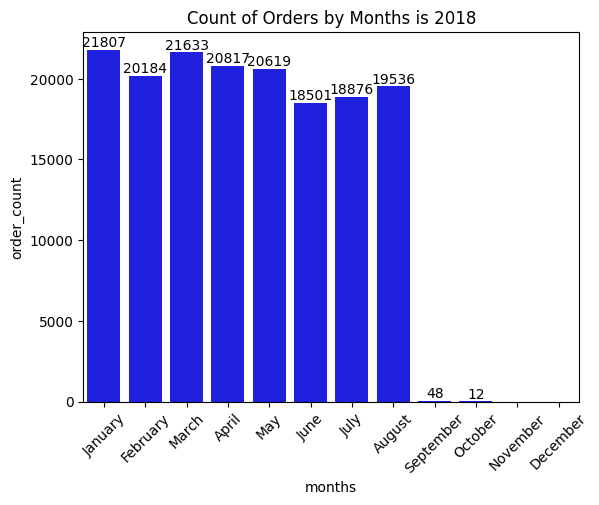

In [12]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months","order_count"])
o = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o, color="blue")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [17]:
query = """ WITH count_per_order AS
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
ON orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, ROUND(AVG(count_per_order.oc), 2) AS average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer City", "Average Products/Orders"])
df.head(10)

,Customer City,Average Products/Orders
0,sao paulo,10.41
1,sao jose dos campos,10.25
2,porto alegre,10.57
3,indaial,10.04
4,treze tilias,11.45
5,rio de janeiro,10.32
6,mario campos,12.00
7,guariba,9.00
8,cuiaba,10.78
9,franca,11.26


# Calculate the percentage of total revenue contributed by each product category.

In [7]:
query = """ select upper(products.product_category) category,
ROUND((SUM(payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100, 2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
GROUP BY products.product_category ORDER BY sales_percentage DESC;
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Percentage Distribution"])
df.head(10)

,Category,Percentage Distribution
0,BED TABLE BATH,96.28
1,HEALTH BEAUTY,93.18
2,COMPUTER ACCESSORIES,89.13
3,FURNITURE DECORATION,80.40
4,WATCHES PRESENT,80.35
5,SPORT LEISURE,78.26
6,HOUSEWARES,61.55
7,AUTOMOTIVE,47.91
8,GARDEN TOOLS,47.13
9,COOL STUFF,43.83


# Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
query = """SELECT products.product_category,COUNT(order_items.product_id) AS total_orders,
ROUND(AVG(order_items.price), 2) AS avg_price
FROM products JOIN order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "order_count", "avg_price"])
arr1 = df["order_count"].values
arr2 = df["avg_price"].values
corr_mat = np.corrcoef(arr1, arr2)
print("The Correlation is", corr_mat[0, 1])

The Correlation is -0.10631514167157556


#  Calculate the total revenue generated by each seller, and rank them by revenue.

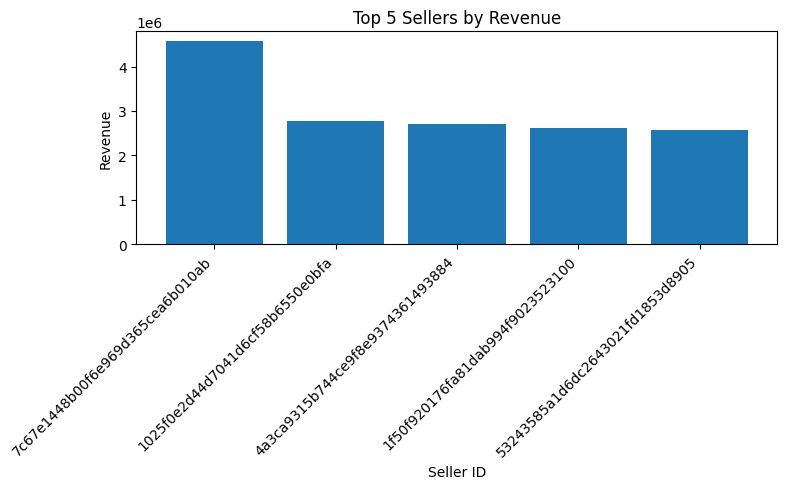

In [21]:
query = """
SELECT
    *,
    DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn
FROM (
    SELECT
        oi.seller_id,
        SUM(p.payment_value) AS revenue
    FROM order_items AS oi
    JOIN payments AS p
      ON oi.order_id = p.order_id
    GROUP BY
        oi.seller_id
) AS sales_per_seller;
"""

# Execute and fetch
cur.execute(query)
data = cur.fetchall()
# assume `data` is already fetched:
df = pd.DataFrame(data, columns=["seller_id", "revenue", "rank"])
df_top5 = df.head()

fig, ax = plt.subplots(figsize=(8, 5))
df_top5 = df.nsmallest(5, "rank")

# Define the tick positions
x_pos = range(len(df_top5))
ax.bar(x_pos, df_top5["revenue"])

# First tell Matplotlib where the ticks go…
ax.set_xticks(x_pos)
# …then what their labels are
ax.set_xticklabels(df_top5["seller_id"], rotation=45, ha="right")

ax.set_xlabel("Seller ID")
ax.set_ylabel("Revenue")
ax.set_title("Top 5 Sellers by Revenue")
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [31]:
# 1) Define a properly balanced, multi-line SQL string:
query = """
SELECT
    customer_id,
    order_purchase_timestamp,
    payment,
    AVG(payment) OVER (
        PARTITION BY customer_id
        ORDER BY order_purchase_timestamp
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) AS mov_avg
FROM (
    SELECT
        o.customer_id,
        o.order_purchase_timestamp,
        p.payment_value AS payment
    FROM payments AS p
    JOIN orders   AS o
      ON p.order_id = o.order_id
) AS a
ORDER BY customer_id, order_purchase_timestamp;
"""

# 2) Execute and fetch:
cur.execute(query)
data = cur.fetchall()

# 3) Load into a DataFrame (with column names matching the SELECT list):
df = pd.DataFrame(
    data,
    columns=[
        "customer_id",
        "order_purchase_timestamp",
        "payment", "mov_avg" ]
)

# 4) Inspect the first few rows:
print(df.head())

                        customer_id order_purchase_timestamp  payment  \
0  00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
1  00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
2  00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
3  00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
4  00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   

      mov_avg  
0  114.739998  
1  114.739998  
2  114.739998  
3  114.739998  
4  114.739998  


# Calculate the cumulative sales per month for each year.


In [37]:
query = """ SELECT
    years,
    months,
    payment,
    SUM(payment) OVER (
        ORDER BY years, months
    ) AS cumulative_sales
FROM (
    SELECT
        YEAR(o.order_purchase_timestamp)  AS years,
        MONTH(o.order_purchase_timestamp) AS months,
        ROUND(SUM(p.payment_value), 2)    AS payment
    FROM orders AS o
    JOIN payments AS p
      ON o.order_id = p.order_id
    GROUP BY
        YEAR(o.order_purchase_timestamp),
        MONTH(o.order_purchase_timestamp)
) AS monthly_totals
ORDER BY
    years,
    months;
    """
cur.execute(query)
data = cur.fetchall() 
df = pd.DataFrame(
    data,
    columns=[
        "years",
        "months",
        "payment", "cumulative_sales" ]
)
print(df)



    years  months      payment  cumulative_sales
0    2016       9      2270.16      2.270160e+03
1    2016      10    531814.32      5.340845e+05
2    2016      12       176.58      5.342611e+05
3    2017       1   1246392.36      1.780653e+06
4    2017       2   2627172.09      4.407826e+06
5    2017       3   4048772.40      8.456598e+06
6    2017       4   3760092.27      1.221669e+07
7    2017       5   5336269.38      1.755296e+07
8    2017       6   4601487.42      2.215445e+07
9    2017       7   5331446.28      2.748589e+07
10   2017       8   6069566.88      3.355546e+07
11   2017       9   6549862.05      4.010532e+07
12   2017      10   7017100.92      4.712242e+07
13   2017      11  10753945.20      5.787637e+07
14   2017      12   7905613.32      6.578198e+07
15   2018       1  10035037.61      7.581702e+07
16   2018       2   8932170.06      8.474919e+07
17   2018       3  10436869.08      9.518606e+07
18   2018       4  10447069.33      1.056331e+08
19   2018       5  1

# Calculate the year-over-year growth rate of total sales.

In [41]:
query = """
WITH a AS (
    SELECT
        YEAR(o.order_purchase_timestamp)    AS years,
        ROUND(SUM(p.payment_value), 2)      AS payment
    FROM orders AS o
    JOIN payments AS p
      ON o.order_id = p.order_id
    GROUP BY YEAR(o.order_purchase_timestamp)
)
SELECT
    years,
    -- compute (this_year - last_year) / last_year * 100
    ((payment 
       - LAG(payment, 1) OVER (ORDER BY years)
     )
     / LAG(payment, 1) OVER (ORDER BY years)
    ) * 100                              AS yoy_pct_growth
FROM a
ORDER BY years;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(
    data,
    columns=["years", "yoy_pct_growth"]
)

print(df)


   years  yoy_pct_growth
0   2016             NaN
1   2017    12112.703758
2   2018       20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [42]:
query = """
WITH a AS (
    SELECT
        c.customer_id,
        MIN(o.order_purchase_timestamp) AS first_order
    FROM customers AS c
    JOIN orders AS o
      ON c.customer_id = o.customer_id
    GROUP BY c.customer_id
),
b AS (
    SELECT
        a.customer_id
    FROM a
    JOIN orders AS o
      ON o.customer_id = a.customer_id
     AND o.order_purchase_timestamp > a.first_order
     AND o.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)
SELECT
    100.0
    * COUNT(DISTINCT b.customer_id)
    / COUNT(DISTINCT a.customer_id) AS retention_rate
FROM a
LEFT JOIN b
  ON a.customer_id = b.customer_id;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["retention_rate"])
print(df)

# Since None of our Customers is Repated That's why our Retention Rate is 0

  retention_rate
0        0.00000


# Identify the top 3 customers who spent the most money in each year.

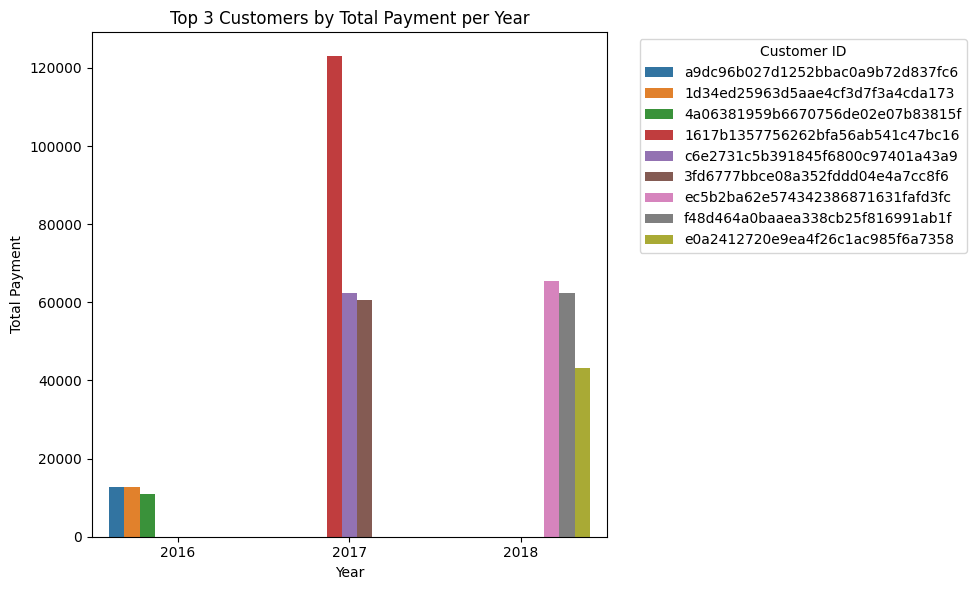

In [43]:
query = """
SELECT
    years,
    customer_id,
    payment,
    d_rank
FROM (
    SELECT
        YEAR(o.order_purchase_timestamp) AS years,
        o.customer_id,
        SUM(p.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY YEAR(o.order_purchase_timestamp)
            ORDER BY SUM(p.payment_value) DESC
        ) AS d_rank
    FROM orders AS o
    JOIN payments AS p
      ON o.order_id = p.order_id
    GROUP BY
        YEAR(o.order_purchase_timestamp),
        o.customer_id
) AS ranked_payments
WHERE d_rank <= 3
ORDER BY years, d_rank;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["year", "customer_id", "payment", "d_rank"])

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x="year",
    y="payment",
    hue="customer_id",
    dodge=True
)
plt.title("Top 3 Customers by Total Payment per Year")
plt.xlabel("Year")
plt.ylabel("Total Payment")
plt.legend(title="Customer ID", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()